# Overview
This notebook implements an autoregression model AR. The model is trained and tested on training/test data and then trained again to predict the unknown future sale values.

### Outline:
- Train AR for one sample store and product
- Predict future sales
- Train AR for all stores and products and generate the predicted data set that can be uploaded to Kaggle

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR, VARMAX
from sklearn import preprocessing

from scipy.stats import wasserstein_distance

C:\Users\Julian\anaconda3\envs\aml\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load data

In [79]:
#load data
train = pd.read_csv('datasets/train.csv',index_col='date',parse_dates=True)
train.head(10)

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0
2013-01-01,5,1,BREAD/BAKERY,0.0,0
2013-01-01,6,1,CELEBRATION,0.0,0
2013-01-01,7,1,CLEANING,0.0,0
2013-01-01,8,1,DAIRY,0.0,0


### Plot data

<AxesSubplot:title={'center':'Store_3 and family=GROCERY I'}, xlabel='date', ylabel='sales'>

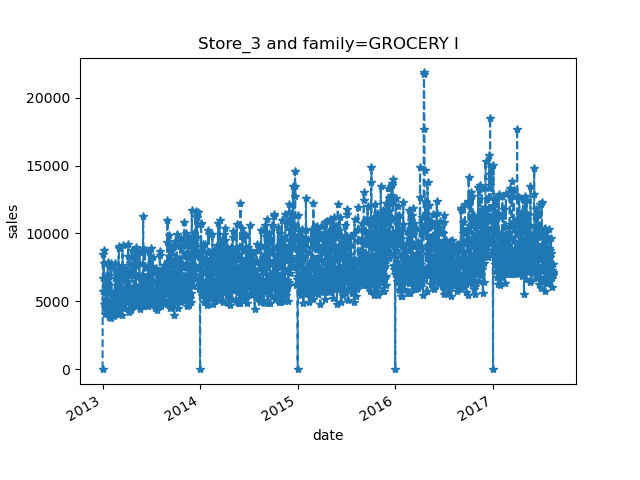

In [4]:
store_nbr = 3
family = 'GROCERY I'
df = train.loc[(train['store_nbr']==store_nbr) & (train['family']==family)]['sales']
plt.figure()
df.plot(ylabel='sales',title='Store_%s and family=%s'%(store_nbr,family),style=['*--'])

### Check if data is stationary
This is needed for the autoregressive model to work. If the p-value of the adfuller test is less than 0.05 we can conclude that the data is stationary and we can use the AR model.

In [5]:
fuller_result = adfuller(df)
print('p_value:%s'%fuller_result[1])

p_value:0.0003504069292831858


### Check Autocorrelation
Autocorrelation tells us something about the optimal number of past values to use in the AR model.

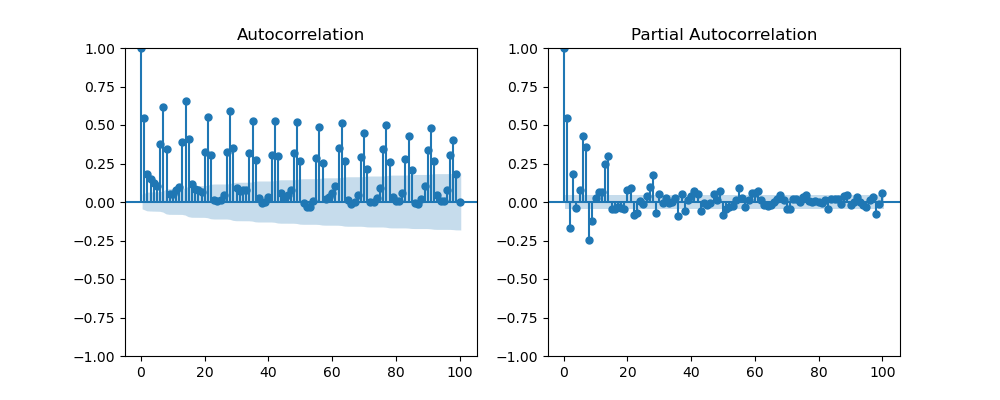

In [71]:
fig=plt.figure(figsize=(10,4))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
plot_acf(df, lags=100,ax=ax1)
plot_pacf(df, lags=100,ax=ax2)
fig.savefig('stored_plots/acf_pacf.png',format='png')

### Train autoregressive model for one store and product

In [29]:
X = df.values
train, test = X[0:len(X)-15], X[len(X)-15:]
model = AutoReg(train, lags = 50, trend='t')
model_fit = model.fit()

In [30]:
# make prediction on the testset
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1,dynamic=False)
predictions = np.round(predictions)
rmse = np.sqrt(mean_squared_error(test,predictions))
wd = wasserstein_distance(test,predictions)
print('RMSE-value: %s'%rmse)
print('Wasserstein-dist: %s'%wd)

RMSE-value: 1093.7333922548646
Wasserstein-dist: 484.20000000000005


In [31]:
df_plot = pd.DataFrame({'sales_pred':predictions,'sales_truth':test},index = df.index[-15:])

<AxesSubplot:title={'center':'AutoReg prediction'}, xlabel='date', ylabel='sales'>

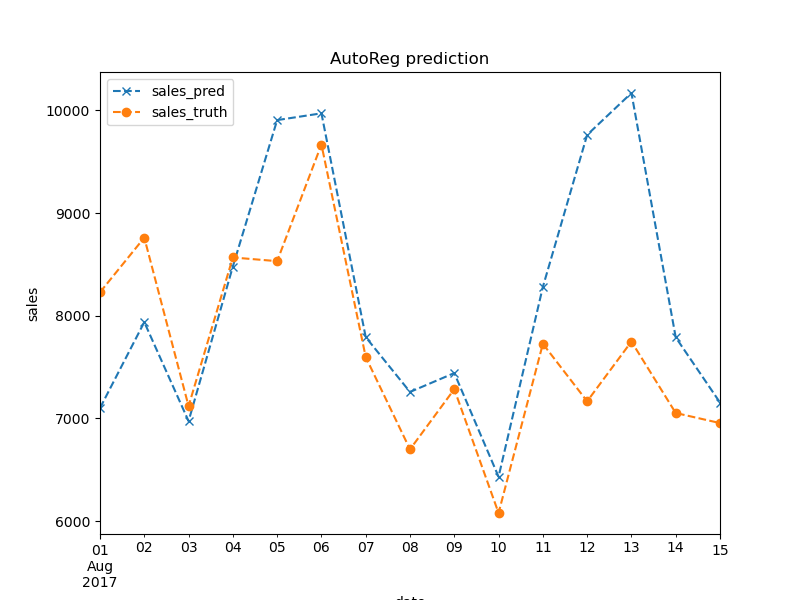

In [32]:
df_plot.plot(style=['x--','o--'],title='AutoReg prediction',ylabel='sales',figsize=(8,6))

### Predict future values

In [76]:
# read test data for correct dates
test = pd.read_csv('datasets/test.csv',index_col='date',parse_dates=True)
test = test.loc[(test['store_nbr']==store_nbr) & (test['family']==family)]
train = df.values
model = AutoReg(train, lags = 50)
model_fit = model.fit()

# predict from 2017-08-16 to 2017-08-31
predictions = model_fit.predict(start=len(train),end=len(train)+15,dynamic=False) 
predictions = np.round(predictions,0)
df_pred = pd.DataFrame(predictions,index=test.index,columns=['sales_pred'])

<AxesSubplot:title={'center':'predictions'}, xlabel='date', ylabel='sales'>

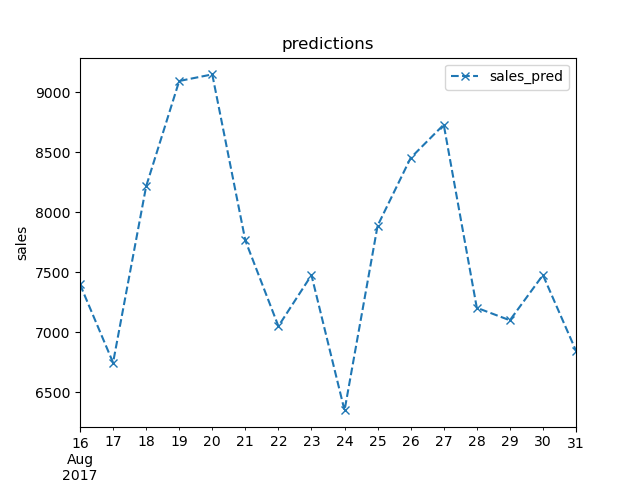

In [77]:
# plot predictions
df_pred.plot(title='predictions',ylabel='sales',style=['x--'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


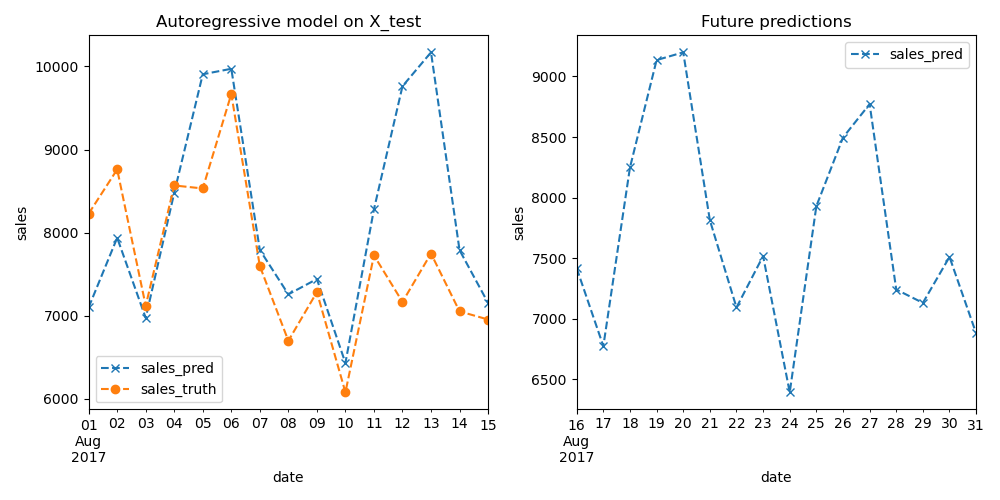

In [65]:
#plot test and prediction in one plot using subplot
fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
df_plot.plot(style=['x--','o--'],title='Autoregressive model on X_test',ylabel='sales',ax=ax1)
df_pred.plot(title='Future predictions',ylabel='sales',style=['x--'],ax=ax2)
fig.tight_layout()
fig.savefig('stored_plots/AutoReg.eps',format='eps')

### Train autoregressive model for all stores and products
Here an autoregressive model is fitted the entire dataset e.g. for each combination of store_nbr and family an autoregressive model is trained and evaluated on the prediction dates. The results are stored in a big matrix and rearranged such that it fits the format of the test data set.

In [4]:
train = pd.read_csv('datasets/train.csv',index_col='date',parse_dates=True)
# include family_id into training set
train['family_id'] = np.tile(np.arange(33),int(3000888/33))
test = pd.read_csv('datasets/test.csv')

In [5]:
num_all_combinations = len(train['store_nbr'].unique())*len(train['family'].unique())
num_pred_days = 16
result_mat = np.zeros((num_all_combinations,num_pred_days))
stores = list(train['store_nbr'].unique())
families = list(train['family_id'].unique())
ctr = 0
# run two for loops to train AutoReg model for each pair of possible compinations (store_nbr,family)
for store in stores:
    for family in families:
        #select store and family
        df = train.loc[(train['store_nbr']==store) & (train['family_id']==family)]
        train_values = df['sales'].values
        model = AutoReg(train_values, lags = 50, trend='t')
        model_fit = model.fit()
        predictions = model_fit.predict(start=len(train_values),end=len(train_values)+num_pred_days-1,dynamic=False) 
        result_mat[ctr,:] = np.round(predictions,0)
        ctr=ctr+1
        
pred = np.reshape(result_mat.T,(result_mat.size,1)).flatten()      
submission_AutoReg = pd.DataFrame({'id':test['id'],'sales':pred})        


In [147]:
# store submission
submission_AutoReg.to_csv('predicted_data/submission_AutoReg.csv',index=False)